<a href="https://colab.research.google.com/github/Chandramani05/Hunting-for-Exoplanet-in-Deep-Space/blob/main/MSML_603_Final_Project_Hunting_the_Exoplanets_in_the_Deep_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing the Environment and Loading the Data

In [22]:
import operator
import itertools
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as ws
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

###Uploading the DataSet 
NASA Cumulative Data 
Link : https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

*It contains 9564 rows with 141 features*

In [23]:
df_exoplanet_full = pd.read_csv('/content/drive/MyDrive/dataset_exoplanets_29.07.2022_ready.csv')
df_exoplanet_full

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,...,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,2455003.539,0.002160,-0.002160,0.0,NaN,NaN,NaN,NaN,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,NaN,NaN,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,LS+MCMC,2.26,0.26,-0.15,0.0853,NaN,NaN,89.66,NaN,NaN,793.0,NaN,NaN,93.59,29.45,-16.65,24.810,2.600,-2.600,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,...,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,NaN,NaN,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,2454995.514,0.003520,-0.003520,0.0,NaN,NaN,NaN,NaN,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,NaN,NaN,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,LS+MCMC,2.83,0.32,-0.19,0.2734,NaN,NaN,89.57,NaN,NaN,443.0,NaN,NaN,9.11,2.87,-1.62,77.900,28.400,-28.400,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,...,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,NaN,NaN,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006

##Data Selection and DataSet Assembly for Training



##Dropping the unnecessary columns

First let's take a look at the missing values as a barplot with the MissingNo library.

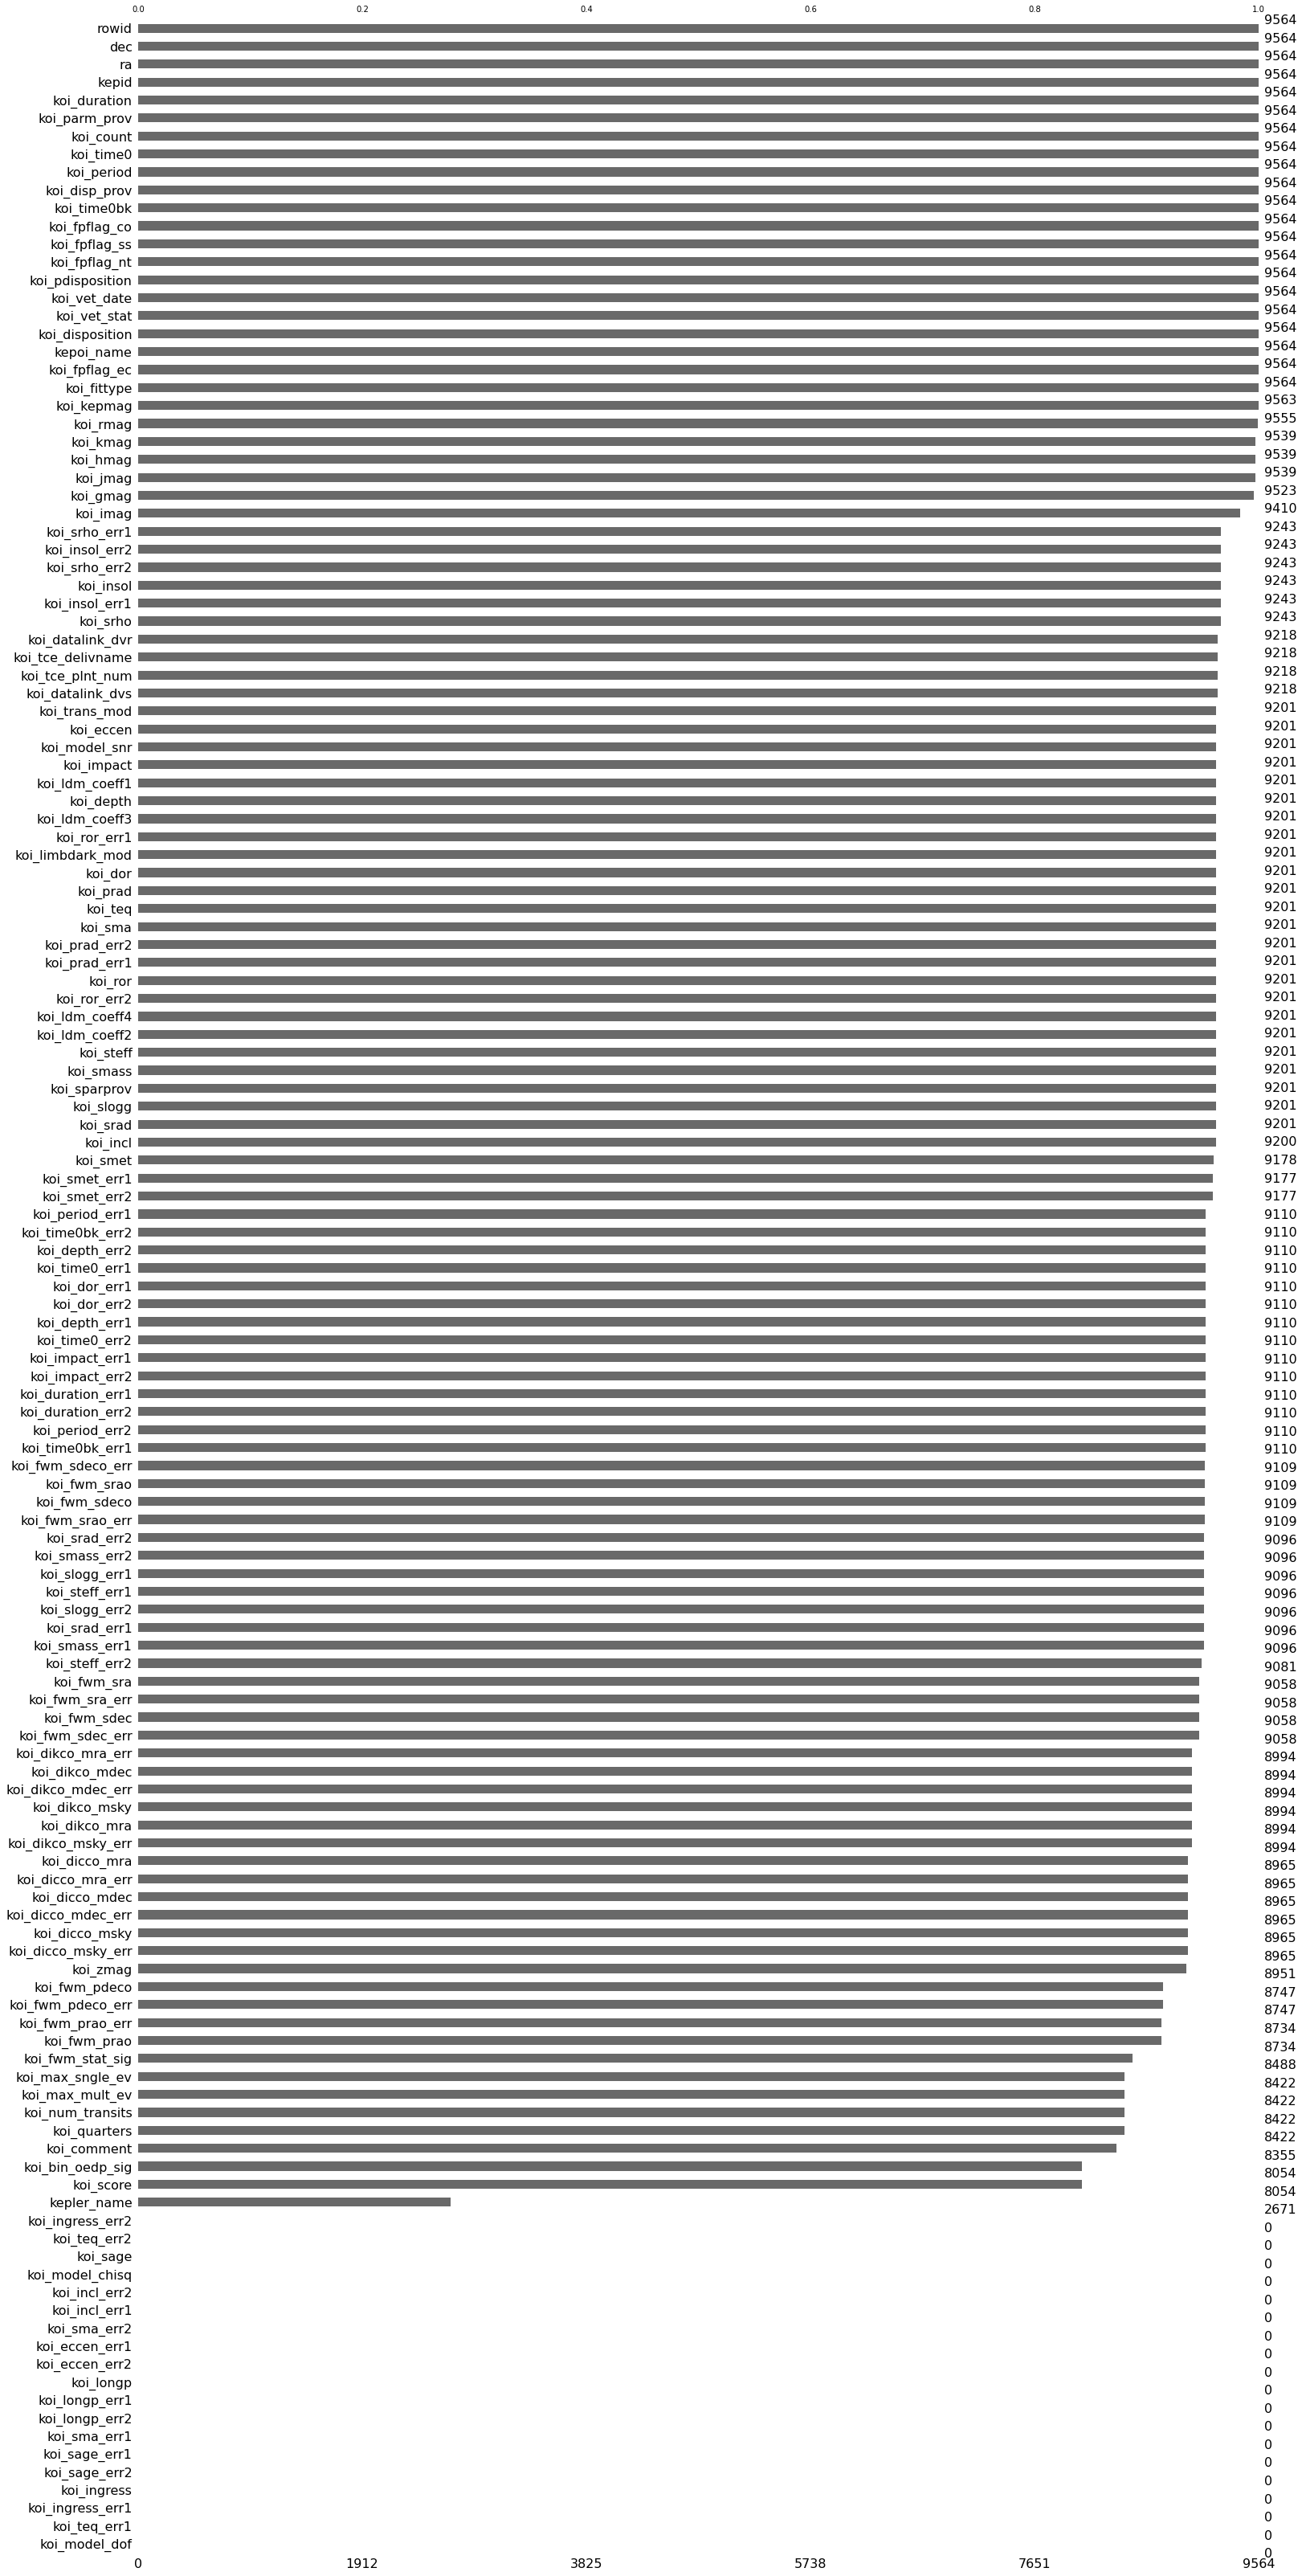

In [24]:
mn.bar(df_exoplanet_full[df_exoplanet_full.isnull().sum().sort_values(ascending=False).index])

Let's first remove all the columns that have all missing values and also the 'kepler_name' column since it's mostly missing values and it doesn't provide any useful info on the disposition anyways. In addition, we'll also remove the column 'koi_time0' and it's corresponding error measurements since it is the same measurement as 'koi_time0bk' just in different units.

In [127]:
# dropping columns with 0 non-null entries
df_exoplanet_data = df_exoplanet_full.copy()
df_exoplanet_data.drop(columns=['koi_vet_stat','koi_vet_date','koi_disp_prov','koi_comment','koi_time0','koi_time0_err1',
                                'koi_time0_err2','koi_eccen_err1','koi_eccen_err2','koi_longp_err1','koi_longp_err2','koi_ingress_err1','koi_ingress_err2',
                                 'koi_ror_err1','koi_ror_err2','koi_srho_err1','koi_srho_err2',
                                'koi_fittype','koi_sma_err1','koi_sma_err2','koi_incl_err1','koi_ror', 'koi_srho',
                                'koi_incl_err2','koi_fpflag_nt', 'koi_sma','koi_incl', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_max_sngle_ev', 'koi_max_mult_ev',
                              'koi_count','koi_num_transits','koi_smass','koi_gmag','koi_rmag','koi_jmag','koi_zmag','koi_imag','koi_hmag','koi_kmag',
                                'koi_dor','koi_dor_err1','koi_dor_err2','koi_limbdark_mod','koi_parm_prov',
                                'koi_tce_delivname','koi_quarters','koi_bin_oedp_sig','koi_trans_mod','koi_model_dof','koi_model_chisq',
                                'koi_datalink_dvr','koi_datalink_dvs',
                                'koi_smet_err1','koi_smet_err2','koi_smass_err1','koi_smass_err2','koi_sage_err1',
                                'koi_sage_err2','koi_sparprov','koi_fwm_stat_sig','koi_fwm_sra','koi_fwm_sra_err','koi_fwm_sdec',
                                'koi_fwm_sdec_err','koi_fwm_srao','koi_fwm_srao_err','koi_fwm_sdeco','koi_fwm_sdeco_err','koi_fwm_prao',
                                'koi_fwm_prao_err','koi_fwm_pdeco','koi_fwm_pdeco_err','koi_dicco_mra','koi_dicco_mra_err','koi_dicco_mdec',
                                'koi_dicco_mdec_err','koi_dicco_msky','koi_dicco_msky_err','koi_dikco_mra','koi_dikco_mra_err',
                                'koi_dikco_mdec','koi_dikco_mdec_err','koi_dikco_msky','koi_dikco_msky_err'],axis=1,inplace=True)


df_exoplanet_data.shape

(9564, 55)

In [128]:
pd.set_option('display.max_columns', 140)
df_exoplanet_data.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,0.0,0.0,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,0.0,0.0,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,0.0,0.0,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,0.0,0.0,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,0.0,0.0,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509


###Finding columns containign only 0 or null values and dropping them

###Removing rrelevant attributes - 'rowid', 'kepid', 'kepoi_name', 'kepler_name'. These attributes are identification and do not represent information in the model

In [129]:
df_exoplanet_data.drop(['rowid', 'kepid', 'kepoi_name'],axis=1,inplace=True)
df_exoplanet_data

,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,0.0,0.0,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,0.0,0.0,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,0.0,0.0,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,0.0,0.0,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,0.0,0.0,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,0.0,NaN,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,NaN,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,0.0,0.0,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.14,0.903,0.237,-0.079,NaN,297.18875,47.093819,14.082
9560,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.0,NaN,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,NaN,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,0.0,0.0,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,-0.04,1.031,0.341,-0.114,NaN,286.50937,47.163219,14.757
9561,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.0,NaN,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,NaN,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,0.0,0.0,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,-0.04,1.041,0.341,-0.114,NaN,294.16489,47.176281,15.385
9562,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.0,NaN,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,NaN,639.1,52.7,-52.7,19.30,0.55,-4.68,557.0,NaN,NaN,22.68,2.07,-10.95,0.0,0.0,14.0,1.0,4989.0,39.0,-128.0,2.992,0.030,-0.027,0.07,7.824,0.223,-1.896,NaN,296

**The koi_disposition attribute is the target**
**It presents 3 possibilities: FALSE POSITIVE**, **CONFIRMED and CANDIDATE**.

 1. FALSE POSITIVE - Confirmed by other methods.
 2. CONFIRMED - Confirmed as an exoplanet
 3. CANDIDATE - Still under evaluation

**The base will be separated into two sets**:
 1. FALSE POSITIVE + CONFIRMED
 2. CANDIDATE

*The first base will be used for training and testing*
*The candidate base can be used to verify which *objects *of interest would be confirmed as planets using the model*.

**There are 38 attributes selected from the original dataset - lists of categories of these attributes have been created for future use**

In [130]:
#df_exoplanets_columns
exoplanet_archeive_information = ['koi_disposition', 'koi_pdisposition']
project_disposition_columns = ['koi_score','koi_fpflag_nt', 'koi_fpflag_ss','koi_fpflag_co', 'koi_fpflag_ec']
transit_properties = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_ldm_coeff2', 'koi_ldm_coeff1']
tce_event_information = ['koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits']
stellar_parameters = ['koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']
kic_parameters = ['ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag']

categories = [exoplanet_archeive_information, project_disposition_columns, transit_properties, tce_event_information, stellar_parameters, kic_parameters]

#Test Parameters

y_feature = ['koi_disposition', 'koi_pdisposition']
features = ['koi_score','koi_fpflag_nt', 'koi_fpflag_ss','koi_fpflag_co', 'koi_fpflag_ec','koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_ldm_coeff2', 'koi_ldm_coeff1','koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits','koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass','ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag']

y_feature

['koi_disposition', 'koi_pdisposition']

#Pre-Processing, Preliminary Analysis of Outliers and Null/Empty Data

##Dataset Balance Analysis

In [131]:
df_exoplanet_data.assign(n=0).groupby(['koi_pdisposition']).n.count()

koi_pdisposition
CANDIDATE         4717
FALSE POSITIVE    4847
Name: n, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


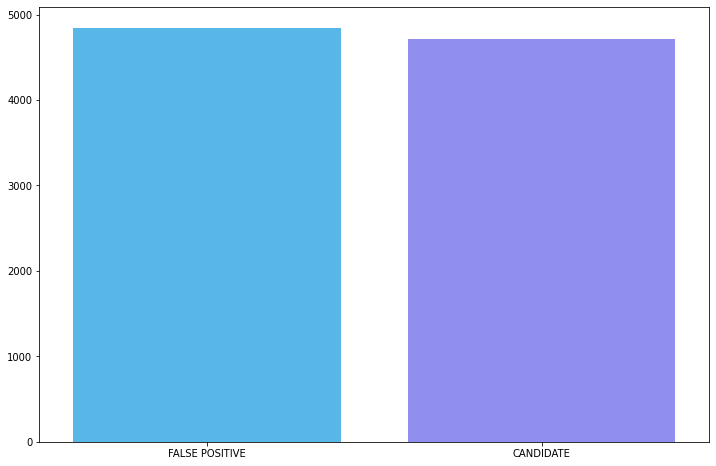

In [132]:
 #Evaluating the balance of the datasets

fig, ax = plt.subplots(figsize = (12,8))
with sns.color_palette("cool", 3):
    sns.barplot(df_exoplanet_data['koi_pdisposition'].value_counts().index, df_exoplanet_data['koi_pdisposition'].value_counts().values)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


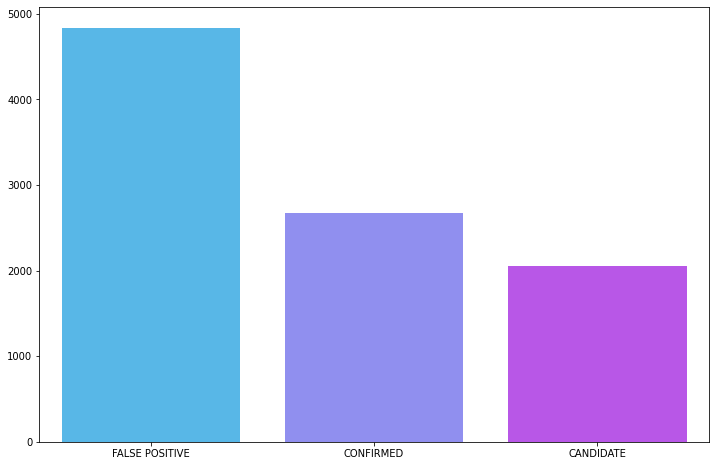

In [133]:
fig, ax = plt.subplots(figsize = (12,8))
with sns.color_palette("cool", 3):
        sns.barplot(df_exoplanet_data['koi_disposition'].value_counts().index, df_exoplanet_data['koi_disposition'].value_counts().values)

###Null and/or Void Data Analysis and Preliminary Outlier Analysis
Need to fill the Null values ​​in the attributes or check if there is relevance in it.

In [134]:
df_exoplanet_data.isna().any()

kepler_name           True
koi_disposition      False
koi_pdisposition     False
koi_score             True
koi_fpflag_ss        False
koi_fpflag_co        False
koi_fpflag_ec        False
koi_period           False
koi_period_err1       True
koi_period_err2       True
koi_time0bk          False
koi_time0bk_err1      True
koi_time0bk_err2      True
koi_eccen             True
koi_longp             True
koi_impact            True
koi_impact_err1       True
koi_impact_err2       True
koi_duration         False
koi_duration_err1     True
koi_duration_err2     True
koi_ingress           True
koi_depth             True
koi_depth_err1        True
koi_depth_err2        True
koi_prad              True
koi_prad_err1         True
koi_prad_err2         True
koi_teq               True
koi_teq_err1          True
koi_teq_err2          True
koi_insol             True
koi_insol_err1        True
koi_insol_err2        True
koi_ldm_coeff4        True
koi_ldm_coeff3        True
koi_model_snr         True
k

###Analsing Attribute koi_score

In [135]:
print("Sum of all null values in koi _score = " + str(df_exoplanet_data.koi_score.isna().sum()))
print(df_exoplanet_data.koi_score.describe())
##Filling the N/A values with 0 as he koi_score is the confidence against the record class. Filling of null values ​​will be according to the worst case.
df_exoplanet_data.koi_score.fillna(0,inplace=True)
print("Sum of all null values in koi _score = " + str(df_exoplanet_data.koi_score.isna().sum()))

Sum of all null values in koi _score = 1510
count    8054.000000
mean        0.480829
std         0.476928
min         0.000000
25%         0.000000
50%         0.334000
75%         0.998000
max         1.000000
Name: koi_score, dtype: float64
Sum of all null values in koi _score = 0


### koi_impact attribute with Outliers values

count    9201.000000
mean        0.735105
std         3.348832
min         0.000000
25%         0.197000
50%         0.537000
75%         0.889000
max       100.806000
Name: koi_impact, dtype: float64


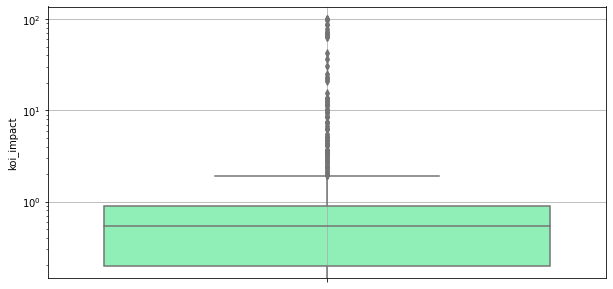

No of Null Values: 0


In [136]:
print(df_exoplanet_data.koi_impact.describe())


fig, ax= plt.subplots(figsize=(10, 5))
ax.set_yscale('log')
g = sns.boxplot(y=df_exoplanet_data["koi_impact"],palette='rainbow', ax = ax)
plt.grid()
plt.show()
# Inserted Average Values
df_exoplanet_data.koi_impact.fillna(df_exoplanet_data.koi_impact.mean(), inplace=True)
print('No of Null Values: ' + str(df_exoplanet_data.koi_impact.isna().sum()))
# For now Outliers held if any significance

### Exploratory analysis of the exoplanet_archive_information CategoryAttributes present in this category


##Data Visualization

In [137]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

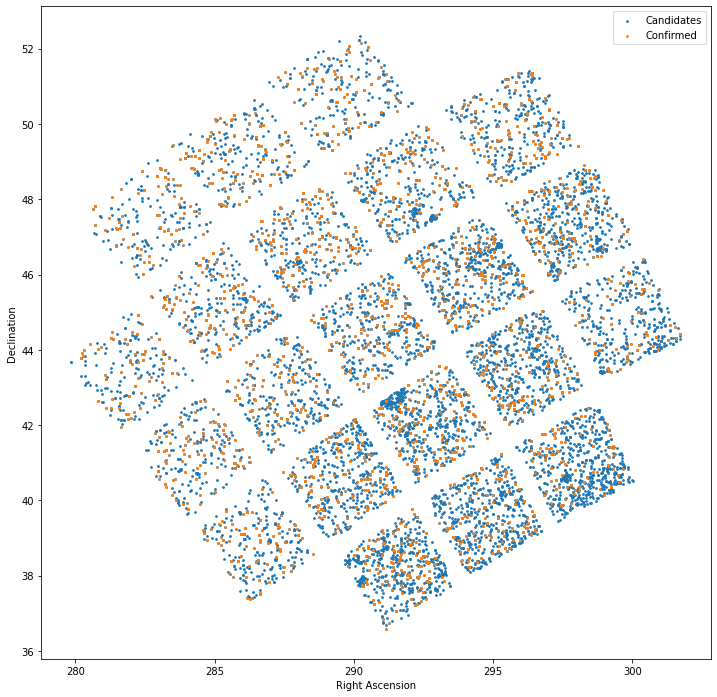

In [138]:
confirmed = df_exoplanet_data[df_exoplanet_data.koi_disposition == 'CONFIRMED']

ra, dec = df_exoplanet_data.ra, df_exoplanet_data.dec
ra_c, dec_c = confirmed.ra, confirmed.dec

fig = plt.figure(figsize=(12, 12))

plt.scatter(ra, dec, s=3, label='Candidates')
plt.scatter(ra_c, dec_c, s=3, label="Confirmed")

plt.xlabel("Right Ascension")
plt.ylabel("Declination")

plt.legend()

Closer to the Milky Way's bulge, or to the side, the density of stars rises.

It's also interesting to notice that the density of the number of confirmed planets does not rise as the arrangement of stars in space gets denser (near to the Milky Way's arm's core). This is most likely caused by how challenging it is to conduct observations in a denser region of space.

Text(0.5, 0, 'Orbital period of confirmed planets, (days)')

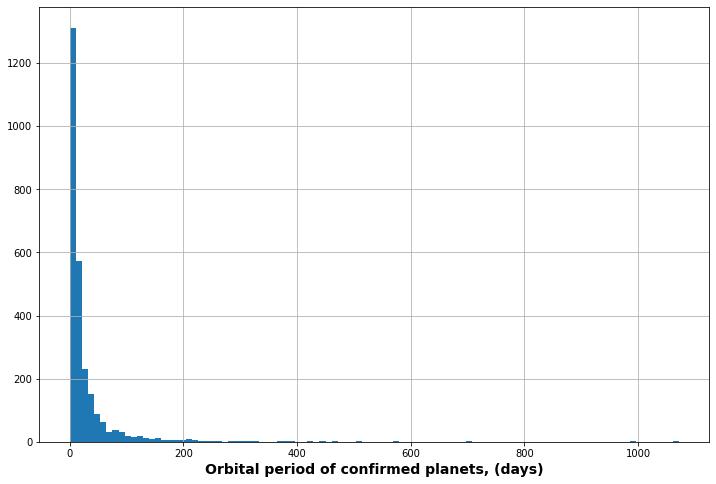

In [139]:
ax = confirmed.koi_period.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Orbital period of confirmed planets, (days)", fontdict= {'size' : '14', 'weight' : 'bold'})

From above graph we see that most of the confirmed planets have lower orbital periods. This makes sense, since the lower the orbital period, the more likely it will be to eclipse it's star (and therefore the more likely it will be observed)

Text(0.5, 1.0, 'Surface gravity of stars with confirmed planets')

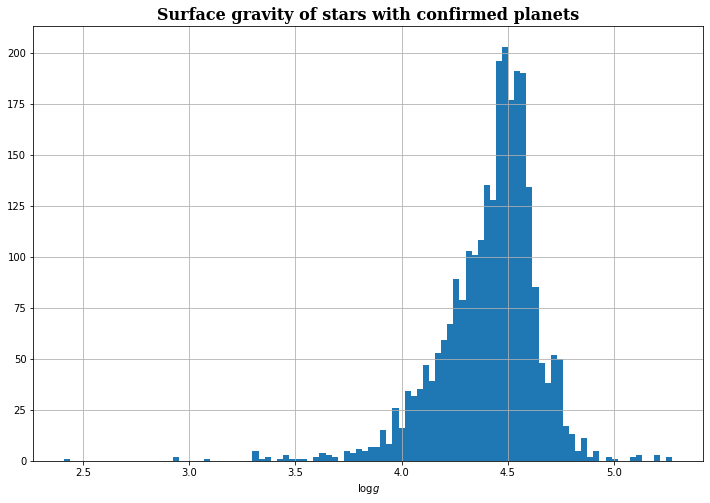

In [140]:
ax = confirmed.koi_slogg.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("$\log{g}$")
ax.set_title("Surface gravity of stars with confirmed planets", font)

Text(0.5, 1.0, 'Сonfirmed')

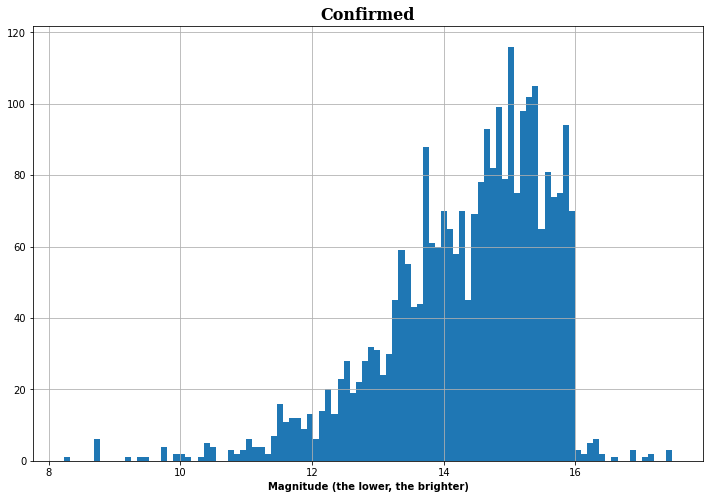

In [141]:
ax = confirmed.koi_kepmag.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Magnitude (the lower, the brighter)", fontdict = {'weight' : 'bold'})
ax.set_title("Сonfirmed", font)

We see a sharp decline around the 16th magnitude. This seems to be the limit at which the noise gets too much to detect planetary candidates.

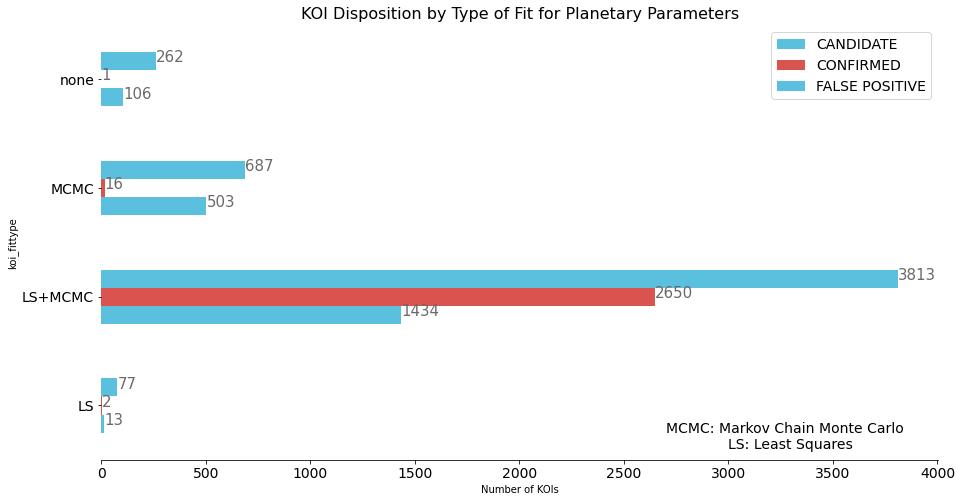

In [143]:
ax = df_exoplanet_full.groupby(['koi_disposition'])['koi_fittype'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#5bc0de', '#d9534f'],
                                                                                   fontsize=14)
ax.annotate('MCMC: Markov Chain Monte Carlo', xy=(10, 0), xytext=(2700, -.25), size=14)
ax.annotate('LS: Least Squares', xy=(10, 0), xytext=(3000, -.4), size=14)
plt.legend(fontsize=14)
plt.title("KOI Disposition by Type of Fit for Planetary Parameters",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of KOIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


Looks like KOIs where the fit type Least Squares was used are all classified as 'FALSE POSITIVE' , and less than 0.47% of KOIs not using any fit and 2.0% of KOIs with using the Markov Chain Monte Carlo fit are classified as 'CONFIRMED'. Let's binarize the 'fittype' feature to create a new column 'LS+MCMC' where it is 1 if LS+MCMC is used and 0 if not.

### **There are 2 options for further research**.


*   We choose koi_pdisposition as the target variable and train our model to recognize the most probable CANDIDATE objects
*   We choose koi_disposition as the target variable and train our model to recognize the most likely CONFIRMED objects.


Since the share of error between CANDIDATE and CONFIRMED is quite small (45 / (2293 + 45)) x100% = 1.92%, we have decided to choose option 1. After all, assignment of the CONFIRMED status.

So, we will classify objects only as either CANDIDATE or FALSE POSITIVE.

In [251]:
# Now we will recode categorical features for further analysis

# Let's write a function that accepts DataFrame as input, encode categorical features with numeric values and returns the updated DataFrame and the encoders themselves.

def nef(init_df):
    result = init_df.copy() # copy of our original table
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # if the column type is a string, then it is encoded
            encoders[column] = LabelEncoder() # creating an encoder for the column
            result[column] = encoders[column].fit_transform(result[column]) # apply the encoder to the column and overwrite the column
    return result, encoders

df_encoded, encoders = nef(df_exoplanet_data) # Now encoded data contains encoded categorical signs 
df_encoded.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,1379,1,0,1.000,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,0.0,0.0,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,1380,1,0,0.969,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,0.0,0.0,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,2671,0,0,0.000,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,0.0,0.0,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,2671,2,1,0.000,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,0.0,0.0,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,2237,1,0,1.000,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,0.0,0.0,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509


##Corelation Matrix

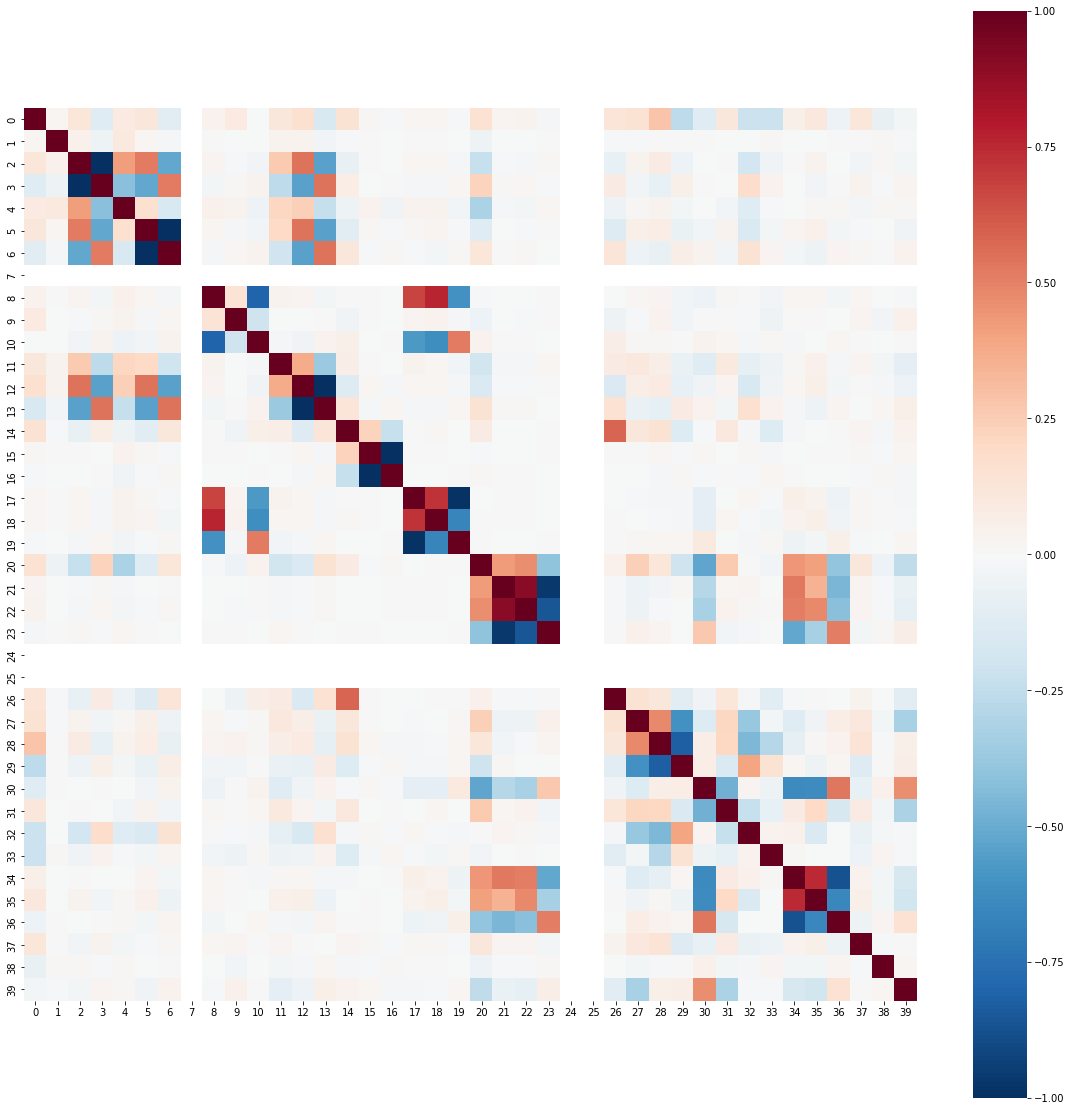

In [287]:
plt.subplots(figsize=(20,20))
sns.heatmap(df_encoded.corr(), square=True, cmap="RdBu_r")
plt.savefig("/content/drive/MyDrive/Exoplanet Detection/Figures/heatmap.png")
plt.show()


From the correlation matrix, it can be seen that kepid is fully correlated with dec.

dec is the KIC (Kepler Input Catalog) Declination -

Kepler Input Catalog: Photometric Calibration and Star Classification.

So, we conclude that KepId tells us the type of star we are observing

In [254]:
df_encoded.drop(['koi_teq_err1', 'koi_teq_err2'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,1379,1,0,1.000,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,0.0,0.0,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,1380,1,0,0.969,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,0.0,0.0,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,2671,0,0,0.000,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,0.0,0.0,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,2671,2,1,0.000,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,0.0,0.0,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,2237,1,0,1.000,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,0.0,0.0,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,2671,2,1,0.000,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,0.0,NaN,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,NaN,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,0.0,0.0,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.14,0.903,0.237,-0.079,NaN,297.18875,47.093819,14.082
9560,2671,0,0,0.497,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.0,NaN,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,NaN,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,0.0,0.0,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,-0.04,1.031,0.341,-0.114,NaN,286.50937,47.163219,14.757
9561,2671,2,1,0.021,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.0,NaN,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,NaN,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,0.0,0.0,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,-0.04,1.041,0.341,-0.114,NaN,294.16489,47.176281,15.385
9562,2671,0,0,0.092,0,0,0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.0,NaN,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,NaN,639.1,52.7,-52.7,19.30,0.55,-4.68,557.0,22.68,2.07,-10.95,0.0,0.0,14.0,1.0,4989.0,39.0,-128.0,2.992,0.030,-0.027,0.07,7.824,0.223,-1.896,NaN,296.76288,47.145142,10.998


We can also remove the koi_disposition parameter (since we decided to use koi_pdisposition earlier).

In addition, the koi_pdisposition and koi_disposition data are highly correlated with each other.

Also, we can safely remove the rowid and kepoi_name columns ( they are just column numbers and object names).

In [255]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepler_name        9564 non-null   int64  
 1   koi_disposition    9564 non-null   int64  
 2   koi_pdisposition   9564 non-null   int64  
 3   koi_score          9564 non-null   float64
 4   koi_fpflag_ss      9564 non-null   int64  
 5   koi_fpflag_co      9564 non-null   int64  
 6   koi_fpflag_ec      9564 non-null   int64  
 7   koi_period         9564 non-null   float64
 8   koi_period_err1    9110 non-null   float64
 9   koi_period_err2    9110 non-null   float64
 10  koi_time0bk        9564 non-null   float64
 11  koi_time0bk_err1   9110 non-null   float64
 12  koi_time0bk_err2   9110 non-null   float64
 13  koi_eccen          9201 non-null   float64
 14  koi_longp          0 non-null      float64
 15  koi_impact         9564 non-null   float64
 16  koi_impact_err1    9110 

In [260]:
df_encoded.drop(['koi_disposition'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,kepler_name,koi_pdisposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,1379,0,1.000,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,0.0,0.0,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,1380,0,0.969,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,0.0,0.0,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,2671,0,0.000,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,0.0,0.0,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,2671,1,0.000,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,0.0,0.0,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,2237,0,1.000,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,0.0,0.0,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,2671,1,0.000,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,0.0,NaN,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,NaN,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,0.0,0.0,453.3,1.0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.14,0.903,0.237,-0.079,NaN,297.18875,47.093819,14.082
9560,2671,0,0.497,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.0,NaN,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,NaN,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,0.0,0.0,10.6,1.0,6119.0,165.0,-220.0,4.444,0.056,-0.224,-0.04,1.031,0.341,-0.114,NaN,286.50937,47.163219,14.757
9561,2671,1,0.021,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.0,NaN,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,NaN,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,0.0,0.0,12.3,1.0,6173.0,193.0,-236.0,4.447,0.056,-0.224,-0.04,1.041,0.341,-0.114,NaN,294.16489,47.176281,15.385
9562,2671,0,0.092,0,0,0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.0,NaN,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,NaN,639.1,52.7,-52.7,19.30,0.55,-4.68,557.0,22.68,2.07,-10.95,0.0,0.0,14.0,1.0,4989.0,39.0,-128.0,2.992,0.030,-0.027,0.07,7.824,0.223,-1.896,NaN,296.76288,47.145142,10.998


##Distribution of Values By Features

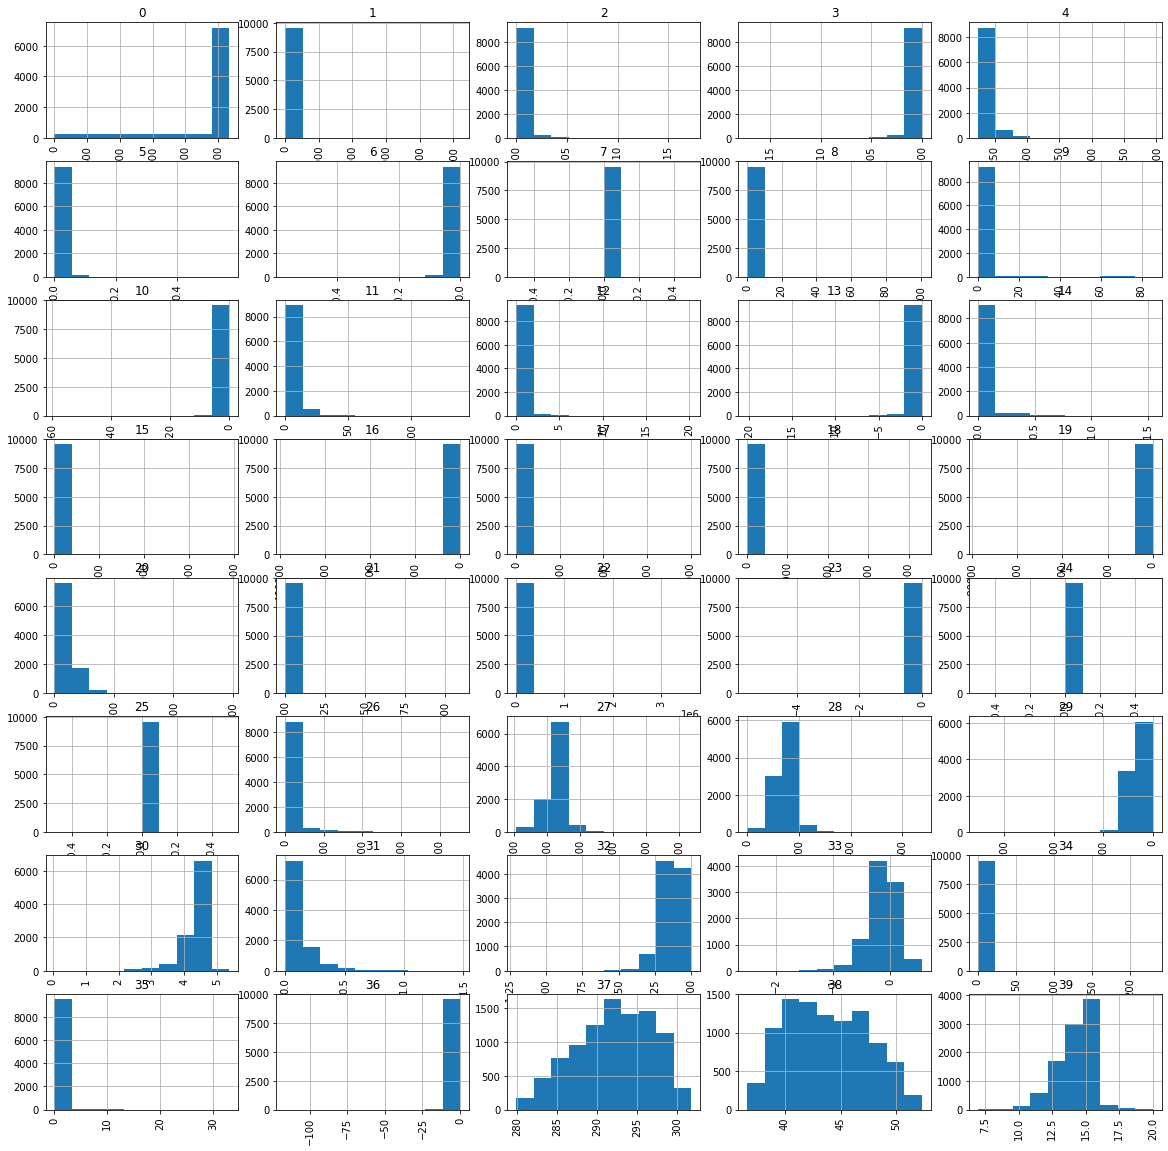

In [286]:
fig = plt.figure(figsize=(20,20))
cols = 5

rows = np.ceil(float(df_encoded.shape[1]) / cols)
for i, column in enumerate(df_encoded.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    df_encoded[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.savefig("/content/drive/MyDrive/Exoplanet Detection/Figures/feature importance") 
plt.show()   

##Gaps in Dataset

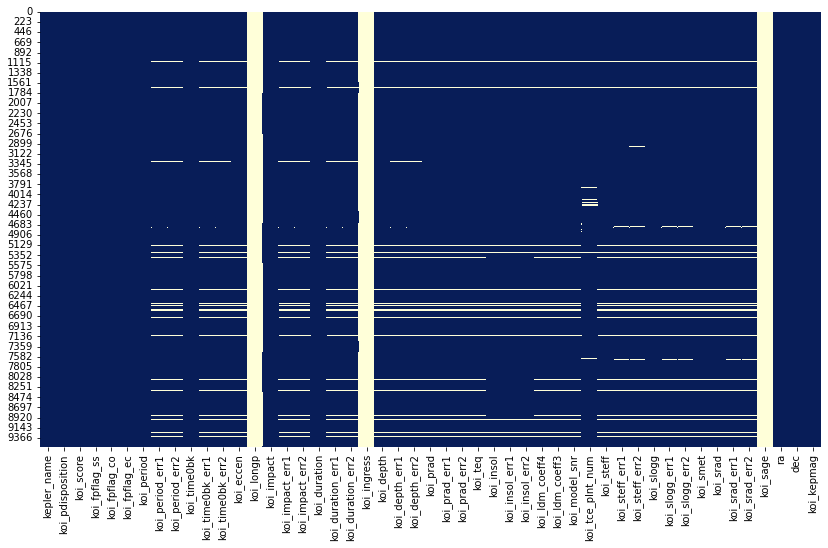

In [262]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df_encoded.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

##Encoding the target class into binary

In [263]:
enc1 = encoders['koi_pdisposition'].transform(['FALSE POSITIVE'])
enc2 = encoders['koi_pdisposition'].transform(['CANDIDATE'])
print(f'CANDIDATE status is encoded as {enc1}')
print(f'FALSE POSITIVE status is encoded as{enc2}')

CANDIDATE status is encoded as [1]
FALSE POSITIVE status is encoded as[0]


In [264]:
df_encoded.drop('koi_score', 1, errors='ignore', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [265]:
df_encoded['koi_tce_plnt_num'].unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.])

We see that many characteristics have missing values.

Most of the omissions are in the koi_score parameter.

As we remember from the description, it is a value between 0 and 1, which indicates the reliability of the Kepler object of interest location.It basically tells us the same thing as the koi_pdisposition. So, it can be removed from the dataset.

koi_tce_plnt_num - exoplanet number, according to the NASA documentation is just an indicator so it can also be excluded.

The other missing characteristics are:

the impact parameter (the distance projected to the sky between the center of the stellar disk and the center of the disk of the planet in conjunction, normalized by the stellar radius),

the transit depth,

the planetary radius,

the insolation flux,

the transit signal-noise,

the photospheric temperature of the star,

and the uncertainty values.

In [266]:
df_encoded.drop('koi_tce_plnt_num', 1, errors='ignore', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [267]:
df_encoded.drop(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,kepler_name,koi_pdisposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_longp,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_ldm_coeff4,koi_ldm_coeff3,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_srad,koi_srad_err1,koi_srad_err2,koi_sage,ra,dec,koi_kepmag
0,1379,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,0.0,0.0,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
1,1380,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,0.0,0.0,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,NaN,291.93423,48.141651,15.347
2,2671,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,NaN,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,NaN,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,0.0,0.0,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,NaN,297.00482,48.134129,15.436
3,2671,1,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,NaN,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,NaN,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,0.0,0.0,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,NaN,285.53461,48.285210,15.597
4,2237,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,NaN,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,NaN,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,0.0,0.0,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,NaN,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,2671,1,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,0.0,NaN,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,NaN,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,0.0,0.0,453.3,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.14,0.903,0.237,-0.079,NaN,297.18875,47.093819,14.082
9560,2671,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.0,NaN,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,NaN,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,0.0,0.0,10.6,6119.0,165.0,-220.0,4.444,0.056,-0.224,-0.04,1.031,0.341,-0.114,NaN,286.50937,47.163219,14.757
9561,2671,1,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.0,NaN,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,NaN,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,0.0,0.0,12.3,6173.0,193.0,-236.0,4.447,0.056,-0.224,-0.04,1.041,0.341,-0.114,NaN,294.16489,47.176281,15.385
9562,2671,0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.0,NaN,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,NaN,639.1,52.7,-52.7,19.30,0.55,-4.68,557.0,22.68,2.07,-10.95,0.0,0.0,14.0,4989.0,39.0,-128.0,2.992,0.030,-0.027,0.07,7.824,0.223,-1.896,NaN,296.76288,47.145142,10.998


In [268]:
y = np.array(df_encoded['koi_pdisposition'].astype('int64'))
df_encoded.drop('koi_pdisposition', errors='ignore', axis = 1, inplace = True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepler_name        9564 non-null   int64  
 1   koi_period         9564 non-null   float64
 2   koi_period_err1    9110 non-null   float64
 3   koi_period_err2    9110 non-null   float64
 4   koi_time0bk        9564 non-null   float64
 5   koi_time0bk_err1   9110 non-null   float64
 6   koi_time0bk_err2   9110 non-null   float64
 7   koi_eccen          9201 non-null   float64
 8   koi_longp          0 non-null      float64
 9   koi_impact         9564 non-null   float64
 10  koi_impact_err1    9110 non-null   float64
 11  koi_impact_err2    9110 non-null   float64
 12  koi_duration       9564 non-null   float64
 13  koi_duration_err1  9110 non-null   float64
 14  koi_duration_err2  9110 non-null   float64
 15  koi_ingress        0 non-null      float64
 16  koi_depth          9201 

##Imputation (Filling the missing values)

In [269]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [158]:
# the name of the dataframe columns will be written to the dummies_columns variable
dummies_columns = list(df_encoded.columns)
print(dummies_columns)
missing_values_table(df_encoded)


['kepler_name', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_longp', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_smet', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_sage', 'ra', 'dec', 'koi_kepmag']
Your selected dataframe has 43 columns.
There are 36 columns that have missing values.


,Missing Values,% of Total Values
koi_sage,9564,100.0
koi_longp,9564,100.0
koi_ingress,9564,100.0
koi_steff_err2,483,5.1
koi_slogg_err2,468,4.9
koi_steff_err1,468,4.9
koi_srad_err2,468,4.9
koi_srad_err1,468,4.9
koi_slogg_err1,468,4.9
koi_depth_err1,454,4.7


In [270]:
##Dropping Column with 100% missing values
df_encoded = df_encoded.drop(['koi_sage','koi_longp', 'koi_ingress'], axis = 1)
missing_values_table(df_encoded)


Your selected dataframe has 40 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
koi_steff_err2,483,5.1
koi_slogg_err2,468,4.9
koi_slogg_err1,468,4.9
koi_steff_err1,468,4.9
koi_srad_err1,468,4.9
koi_srad_err2,468,4.9
koi_period_err1,454,4.7
koi_period_err2,454,4.7
koi_time0bk_err1,454,4.7
koi_time0bk_err2,454,4.7


In [271]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

In [272]:
data_with_imputed_values = my_imputer.fit_transform(df_encoded)
data_with_imputed_values.shape

(9564, 40)

In [273]:
# Let's write the resulting array completely into our dataframe
df_encoded=pd.DataFrame(data_with_imputed_values)
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1379.0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,0.0,0.0,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1380.0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,0.0,0.0,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,2671.0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,0.0,0.0,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,2671.0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,0.0,0.0,505.6,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,2237.0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,0.0,0.0,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,2671.0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,0.0,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,4500.53,3406.38,-1175.26,0.0,0.0,453.3,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.14,0.903,0.237,-0.079,297.18875,47.093819,14.082
9560,2671.0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.0,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,1585.81,1537.86,-502.22,0.0,0.0,10.6,6119.0,165.0,-220.0,4.444,0.056,-0.224,-0.04,1.031,0.341,-0.114,286.50937,47.163219,14.757
9561,2671.0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.0,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,5713.41,5675.74,-1836.94,0.0,0.0,12.3,6173.0,193.0,-236.0,4.447,0.056,-0.224,-0.04,1.041,0.341,-0.114,294.16489,47.176281,15.385
9562,2671.0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.0,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,639.1,52.7,-52.7,19.30,0.55,-4.68,557.0,22.68,2.07,-10.95,0.0,0.0,14.0,4989.0,39.0,-128.0,2.992,0.030,-0.027,0.07,7.824,0.223,-1.896,296.76288,47.145142,10.998


##Shuffling the Samples

In [165]:
FALSE_POSITIVE = np.argwhere(y == 1).flatten()
print('Number of FALSE POSITIVEs', len(FALSE_POSITIVE))
FALSE_POSITIVE

Number of FALSE POSITIVEs 4847


array([   3,    8,   14, ..., 9559, 9561, 9563])

In [166]:
from sklearn.utils import shuffle

FALSE_POSITIVE = shuffle(FALSE_POSITIVE, random_state = 40)
# find the "extra" ones, for this we cut the found id by the number of CANDIDATE (inside len)
FALSE_POSITIVE = FALSE_POSITIVE[:len(np.argwhere(y == 0).flatten())]
print(len(FALSE_POSITIVE))
# display the number and the id themselves, which we should throw out
FALSE_POSITIVE

4717


array([8906, 4139, 8415, ..., 4953, 4357, 4384])

Checking if datasets are balanced now

In [167]:
len(np.argwhere(y == 0).flatten()) == len(FALSE_POSITIVE)

True

**Creating training dataset X**


In [169]:
X = np.array(df_encoded[df_encoded._get_numeric_data().columns])
X

array([[1.37900000e+03, 9.48803557e+00, 2.77500000e-05, ...,
        2.91934230e+02, 4.81416510e+01, 1.53470000e+01],
       [1.38000000e+03, 5.44183827e+01, 2.47900000e-04, ...,
        2.91934230e+02, 4.81416510e+01, 1.53470000e+01],
       [2.67100000e+03, 1.98991399e+01, 1.49400000e-05, ...,
        2.97004820e+02, 4.81341290e+01, 1.54360000e+01],
       ...,
       [2.67100000e+03, 6.81401611e-01, 2.43400000e-06, ...,
        2.94164890e+02, 4.71762810e+01, 1.53850000e+01],
       [2.67100000e+03, 3.33486169e+02, 4.23500000e-03, ...,
        2.96762880e+02, 4.71451420e+01, 1.09980000e+01],
       [2.67100000e+03, 4.85603482e+00, 6.35600000e-05, ...,
        2.97009770e+02, 4.71210210e+01, 1.48260000e+01]])

In [170]:
X = X[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]
y = y[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]

Displaying the final size of the features

X - training Set

Y - Output Feature

In [171]:
X.shape, y.shape
pd.Series(y).value_counts()

1    4717
0    4717
dtype: int64

##Normalizing The Data


In [172]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[ 5.19281493e-01, -5.58388707e-02, -1.84575883e-04, ...,
         2.17460776e-01, -4.95524497e-01, -2.93085731e+00],
       [ 5.19281493e-01, -2.56574014e-02,  1.03808262e-01, ...,
        -4.81413799e-01, -1.17467156e+00, -2.48020885e+00],
       [ 5.19281493e-01, -5.51168499e-02, -2.61067833e-01, ...,
        -4.24758726e-01, -1.54278788e+00,  6.77941336e-01],
       ...,
       [ 5.19281493e-01,  2.17293551e-01,  3.27269651e-01, ...,
         1.19227000e+00,  8.73997947e-01,  1.05059295e+00],
       [ 5.19281493e-01, -5.52294937e-02, -2.64474967e-01, ...,
        -1.16259428e+00,  9.29948080e-01,  3.55843237e-01],
       [ 5.19281493e-01,  1.91648012e-01,  2.58779542e-01, ...,
         9.88538312e-01,  9.24933401e-01, -2.35888042e+00]])

In [66]:
X_scaled.shape, y.shape

((9434, 107), (9434,))

##Dividing the Dataset into 85% training and 15% test set

In [173]:
from sklearn.model_selection import train_test_split
d = {}
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.15, random_state = 0)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (8018, 40)
Shape of y_train : (8018,)
Shape of x_test : (1416, 40)
Shape of y_test : (1416,)


#Training the Model using different classifiers 

1. Logistic Regression
2. KNN
3. Random Forest
4. SVM
5. Neural Network (CNN)
6. XGBoost

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

Feature ranking:


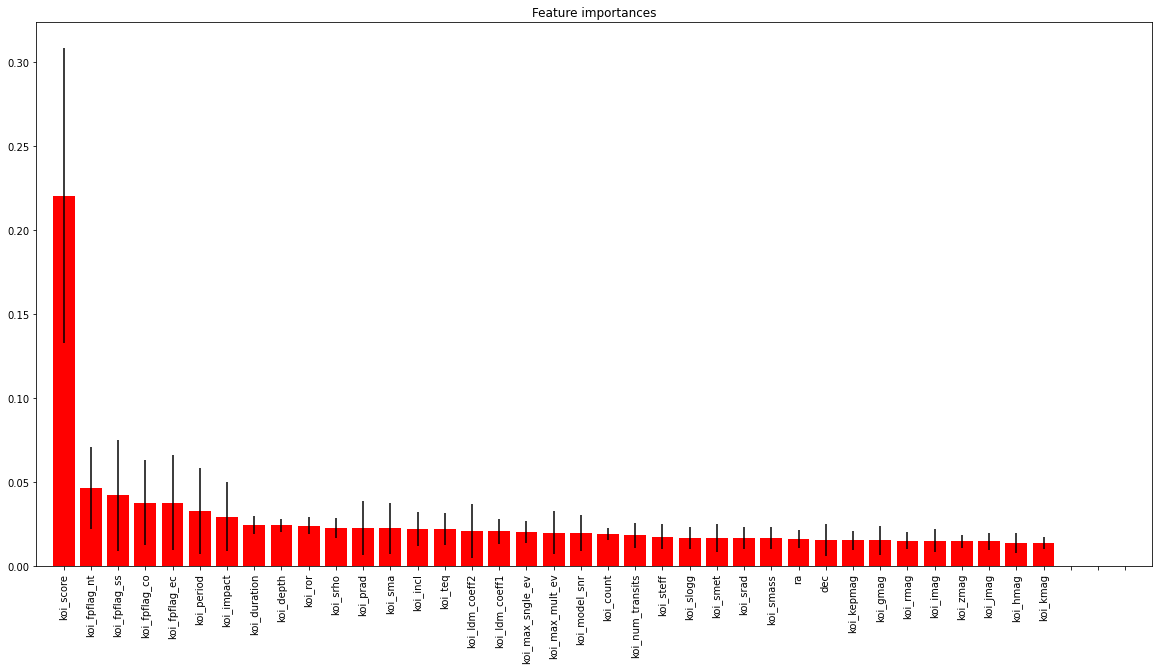

In [285]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1] #reordering features by importance
sorted_importances = [importances[index] for index in indices]
# Print the feature ranking
print("Feature ranking:")


# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1,x_train.shape[1]])

plt.savefig('/content/drive/MyDrive/Exoplanet Detection/Figures/Feature Importances.png')
plt.show()

In [ ]:
X_train100 = x_train
X_train75 = x_train *.75
X_train50 = x_train *.5
X_train25 = x_train *.25

##Common Functions for Plots and Scores

###*ROC Curves*

In [176]:
def plot_roc_curve(predictions) :
  fpr, tpr, _ = roc_curve(predictions, y_test, drop_intermediate=False)
  plt.figure(figsize=(12,6))
  # Adding the ROC
  plt.plot(fpr, tpr, color='red',
  lw=2, label='ROC curve')
  # Random FPR and TPR
  plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
  # Title and label
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  plt.title('ROC curve')
  plt.show()

###*Confusion matrix*

###Printing Scores

In [177]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [178]:
def print_scores(y_pred) :
  	
  print('Precision: %.3f' % precision_score(y_test, y_pred))
  print('Recall: %.3f' % recall_score(y_test, y_pred))
  print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
  print('F1 Score: %.3f' % f1_score(y_test, y_pred))


In [179]:
import os
def plot_confusion_matrix(predictions, model):
  cm = confusion_matrix(predictions, y_test)
  ax = plt.figure(figsize=(12,8))
  path = '/content/drive/MyDrive/Exoplanet Detection/Figures'
  title = "Confusion Matrix For "  + model + '.png'
  titleCM = "Confusion Matrix For "  + model
  pathmain = os.path.join(path, title)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm ,annot = labels, fmt = '',cmap = 'Blues')
  ax.set_title(titleCM, fontdict = {'weight' : 'bold', 'size' : '16'})
  # classification report
  ax.figure.savefig(pathmain)
  cr = classification_report(predictions, y_test)
  print(cr)

#Logistic Regression

In [180]:
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):  
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    # x - the number of neighbors, y - accuracy
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [181]:
grid={"C": np.logspace(-2, 4, 20), "penalty":["l2"] }

logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, grid, cv=5)

# learning
logreg_cv.fit(x_train, y_train)

logreg_cv.best_params_, logreg_cv.best_score_


({'C': 263.6650898730355, 'penalty': 'l2'}, 0.8363686074893864)

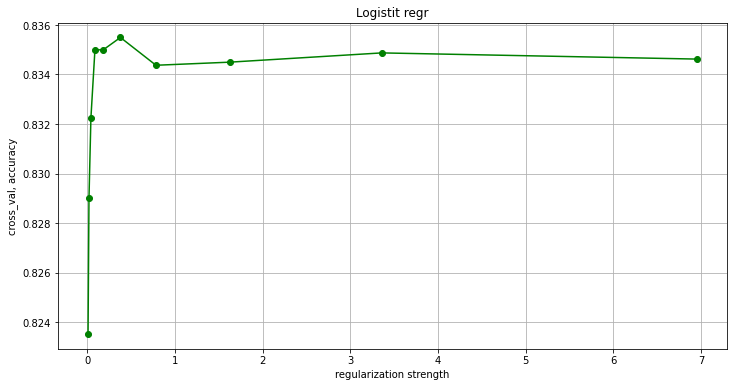

In [182]:
grid_plot(logreg_cv.cv_results_['param_C'][:10], logreg_cv.cv_results_['mean_test_score'][:10], 'regularization strength', 'Logistit regr')

In [183]:
predictions = logreg_cv.predict(x_test)
predictions

array([1, 0, 1, ..., 0, 1, 1])

##PLotting the ROC Curve

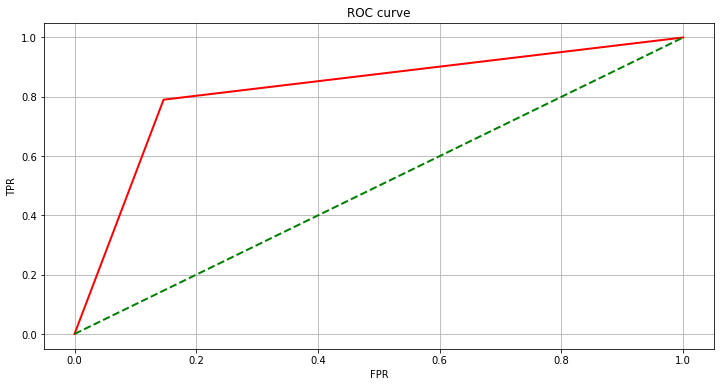

In [184]:
plot_roc_curve(predictions=predictions)

##Confusion Matrix

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       663
           1       0.86      0.79      0.82       753

    accuracy                           0.82      1416
   macro avg       0.82      0.82      0.82      1416
weighted avg       0.82      0.82      0.82      1416



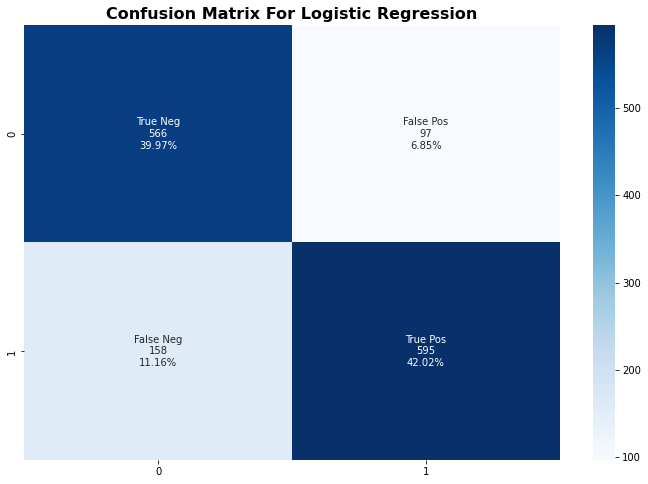

In [185]:
plot_confusion_matrix(predictions, "Logistic Regression")

##Scores

In [186]:
print_scores(predictions)

Precision: 0.790
Recall: 0.860
Accuracy: 0.820
F1 Score: 0.824


#KNN

In [187]:
from sklearn.neighbors import KNeighborsClassifier

# We initialize the algorithm
knn = KNeighborsClassifier()

estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}
                   
# with GridSearch
gs_knn = grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

# We train the model
gs_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': (20, 40, 1),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 10, 1), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

###Best Params

In [188]:
print("\n The best score across ALL searched params:\n",gs_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_knn.best_params_)


 The best score across ALL searched params:
 0.8263891892228257

 The best parameters across ALL searched params:
 {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


##Prediction

In [189]:
predictions_knn = gs_knn.predict(x_test)
predictions_knn

array([1, 0, 1, ..., 0, 1, 1])

##Plotting the ROC Curve

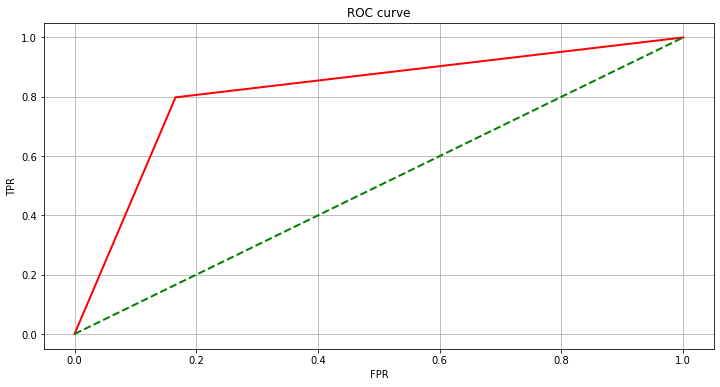

In [190]:
plot_roc_curve(predictions=predictions_knn)

##Confusion Matrix

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       693
           1       0.83      0.80      0.82       723

    accuracy                           0.82      1416
   macro avg       0.82      0.82      0.82      1416
weighted avg       0.82      0.82      0.82      1416



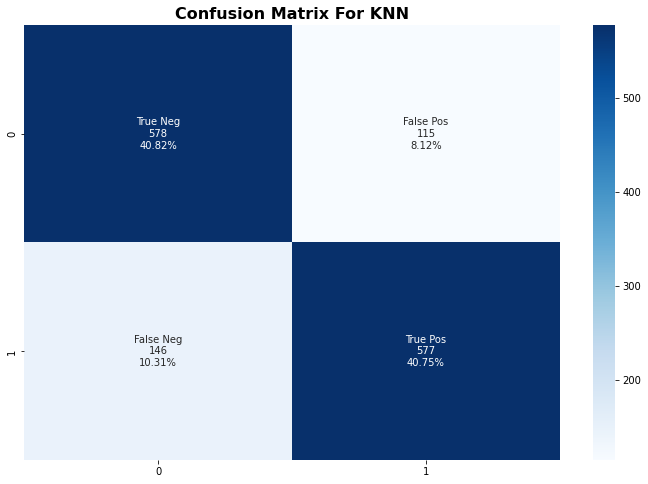

In [191]:
plot_confusion_matrix(predictions=predictions_knn, model= "KNN")

#Random Forest

In [192]:
from sklearn.ensemble import RandomForestClassifier

In [193]:
rfc=RandomForestClassifier(random_state=42)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}                 
# with GridSearch
gs_rf = RandomizedSearchCV(rfc, param_grid, scoring='average_precision', cv=5, random_state=10)

# We train the model
gs_rf.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=10, scoring='average_precision')

In [194]:
print("\n The best score across ALL searched params:\n",gs_rf.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_rf.best_params_)


 The best score across ALL searched params:
 0.941703268175627

 The best parameters across ALL searched params:
 {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [195]:
prediction = gs_rf.predict(x_test)
prediction

array([1, 0, 1, ..., 0, 1, 1])

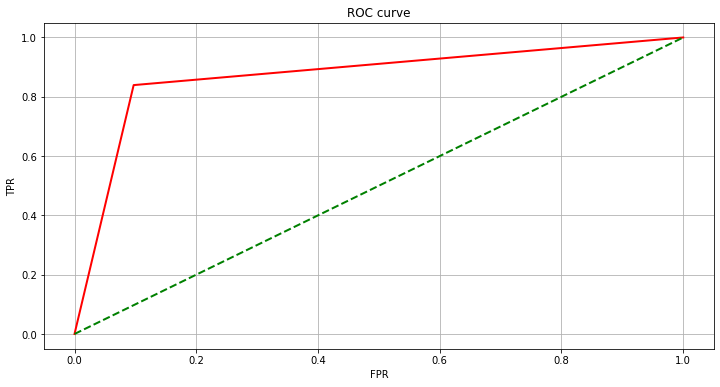

In [196]:
plot_roc_curve(prediction)

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       669
           1       0.91      0.84      0.87       747

    accuracy                           0.87      1416
   macro avg       0.87      0.87      0.87      1416
weighted avg       0.87      0.87      0.87      1416



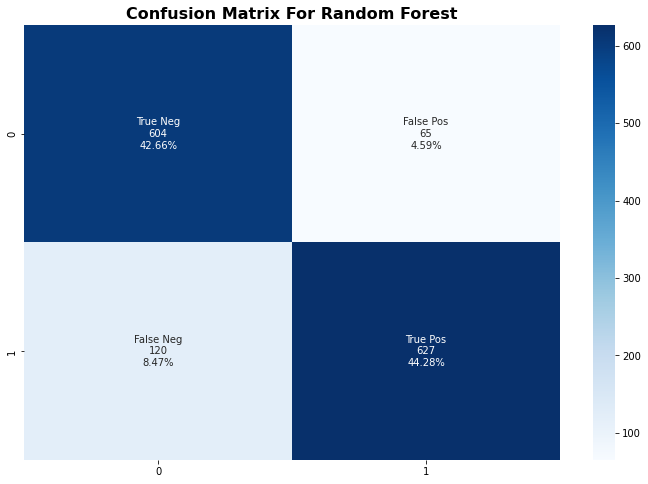

In [197]:
plot_confusion_matrix(prediction, "Random Forest")

#SVM

In [198]:
from sklearn.svm import SVC 

In [200]:
c_space = [0.001, 0.10, 0.1, 10, 25, 50, 100, 200]
gamma_space = [1e-2, 1e-3, 1e-4, 1e-5]
kernels = ['rbf', 'linear', 'sigmoid']
svm_param_grid = {'C': c_space, 'gamma': gamma_space, 'kernel': kernels}

gs_svc = RandomizedSearchCV(SVC(),svm_param_grid,
    cv = 5, random_state= 42)

# We train the model
gs_svc.fit(x_train, y_train)             


RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.001, 0.1, 0.1, 10, 25, 50, 100,
                                              200],
                                        'gamma': [0.01, 0.001, 0.0001, 1e-05],
                                        'kernel': ['rbf', 'linear', 'sigmoid']},
                   random_state=42)

In [201]:
print("\n The best score across ALL searched params:\n",gs_svc.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_svc.best_params_)


 The best score across ALL searched params:
 0.8378649446253362

 The best parameters across ALL searched params:
 {'kernel': 'linear', 'gamma': 1e-05, 'C': 200}


In [202]:
prediction = gs_rf.predict(x_test)
prediction

array([1, 0, 1, ..., 0, 1, 1])

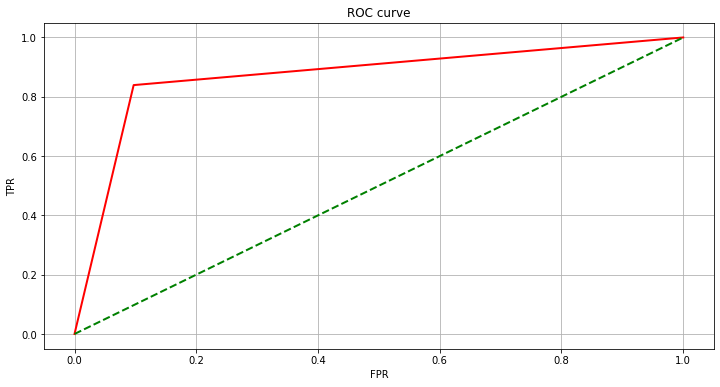

In [203]:
plot_roc_curve(prediction)

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       669
           1       0.91      0.84      0.87       747

    accuracy                           0.87      1416
   macro avg       0.87      0.87      0.87      1416
weighted avg       0.87      0.87      0.87      1416



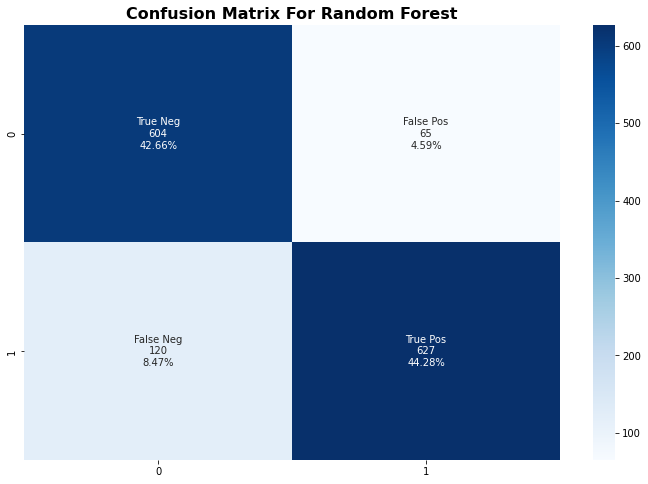

In [204]:
plot_confusion_matrix(prediction, "SVM")

#Neural Network

In [219]:
# Neural network.
# import serial model
from keras.models import Sequential
# import the mesh layer
from keras.layers import Dense

In [220]:
model = Sequential()
model.add(Dense(128, input_dim=40, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [221]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss="mean_squared_error",optimizer='adam', metrics=["binary_accuracy"]) 

7217


##Creating a Neural Network

In [218]:
x_train.shape

(8018, 40)

In [222]:
# train a model with a batch in 32, in 50 epochs, check by test
history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs=200,
                    batch_size=32)
# final check
results = model.evaluate(x_test, y_test)
print("Test loss and accuracy", results)

Epoch 1/200
251/251 [==============================] - 4s 10ms/step - loss: 0.1273 - binary_accuracy: 0.8154 - val_loss: 0.1169 - val_binary_accuracy: 0.8284
Epoch 2/200
251/251 [==============================] - 1s 3ms/step - loss: 0.1047 - binary_accuracy: 0.8491 - val_loss: 0.1110 - val_binary_accuracy: 0.8425
Epoch 3/200
251/251 [==============================] - 1s 3ms/step - loss: 0.0985 - binary_accuracy: 0.8572 - val_loss: 0.1102 - val_binary_accuracy: 0.8340
Epoch 4/200
251/251 [==============================] - 1s 3ms/step - loss: 0.0942 - binary_accuracy: 0.8693 - val_loss: 0.1058 - val_binary_accuracy: 0.8489
Epoch 5/200
251/251 [==============================] - 1s 3ms/step - loss: 0.0934 - binary_accuracy: 0.8666 - val_loss: 0.1074 - val_binary_accuracy: 0.8362
Epoch 6/200
251/251 [==============================] - 1s 3ms/step - loss: 0.0903 - binary_accuracy: 0.8705 - val_loss: 0.1111 - val_binary_accuracy: 0.8340
Epoch 7/200
251/251 [==============================] - 1s

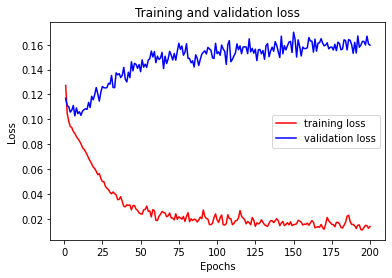

In [223]:
plt.clf()
history_dict = history.history
# get values ​​from the saved dictionary with history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'r', label='training loss')
plt.plot(epochs, val_loss_values, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [224]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


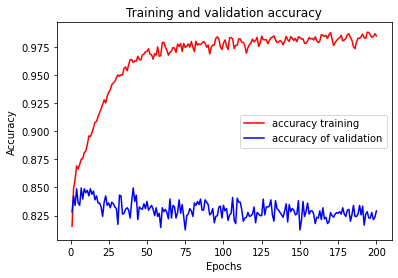

In [225]:
# accuracy on the validation set
plt.clf()
# get values ​​from the saved dictionary with history

acc_values = history.history['binary_accuracy']

val_acc_values = history_dict['val_binary_accuracy']

epochs = range(1, (len(history_dict['binary_accuracy']) + 1))

# build graphs for accuracy on train and val
plt.plot(epochs, acc_values, 'r', label='accuracy training')
plt.plot(epochs, val_acc_values, 'b', label='accuracy of validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [228]:
# we will get predictions from it according to the model
from sklearn.metrics import classification_report
predictions = model.predict(x_test)
print('The raw look of our predictions')
# round the predictions towards 0 or 1, comparing with the test
print(classification_report(y_test, np.around(predictions)))

45/45 [==============================] - 0s 3ms/step
The raw look of our predictions
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       724
           1       0.82      0.84      0.83       692

    accuracy                           0.83      1416
   macro avg       0.83      0.83      0.83      1416
weighted avg       0.83      0.83      0.83      1416



In [229]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,889
Trainable params: 21,889
Non-trainable params: 0
_________________________________________________________________


#XGBoost

##Hyperparameter Tuning

In [276]:
xgb = XGBClassifier(subsample=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state=7)
xgb_steps = [('scaler', StandardScaler()), ('XGB', xgb)]
xgb_pipeline = Pipeline(xgb_steps)

# paramater space to tune
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 5000, num = 10)]
max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
min_child_weight = [1, 3, 5, 7]
gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
colsample_bytree = [0.3, 0.4, 0.5 , 0.7]

xgb_param_grid = {'XGB__max_depth': max_depth, 
                  'XGB__learning_rate': learning_rate, 
                  'XGB__n_estimators': n_estimators, 
                  'XGB__gamma': gamma, 
                  'XGB__min_child_weight': min_child_weight, 
                  'XGB__colsample_bytree': colsample_bytree,
}

In [277]:
%%time
# find best parameters and apply 5 fold cross validation with RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='average_precision', cv=5, random_state=1)
xgb_cv.fit(x_train, y_train)

CPU times: user 30min 33s, sys: 57.5 s, total: 31min 31s
Wall time: 17min 43s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('XGB',
                                              XGBClassifier(nthread=4,
                                                            random_state=7,
                                                            subsample=0.8))]),
                   param_distributions={'XGB__colsample_bytree': [0.3, 0.4, 0.5,
                                                                  0.7],
                                        'XGB__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'XGB__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'XGB__max_depth': [3, 4, 5, 6, 8, 10,
                                                           12, 15],
                                        'XGB__min_child_weight': [1, 3, 5, 7],
  

In [283]:
print("\n The best score across ALL searched params:\n",xgb_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",xgb_cv.best_params_)


 The best score across ALL searched params:
 0.9419533434328228

 The best parameters across ALL searched params:
 {'XGB__n_estimators': 200, 'XGB__min_child_weight': 1, 'XGB__max_depth': 3, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.1, 'XGB__colsample_bytree': 0.5}


In [284]:
prediction = xgb_cv.predict(x_test)
prediction

array([0, 0, 1, ..., 0, 1, 1])

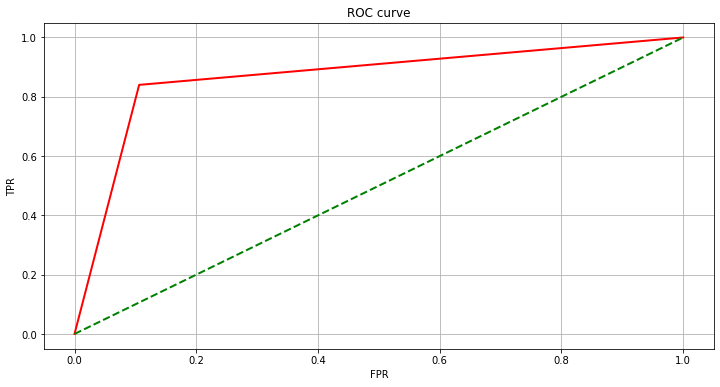

In [281]:
plot_roc_curve(prediction)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       678
           1       0.90      0.84      0.87       738

    accuracy                           0.87      1416
   macro avg       0.87      0.87      0.87      1416
weighted avg       0.87      0.87      0.87      1416



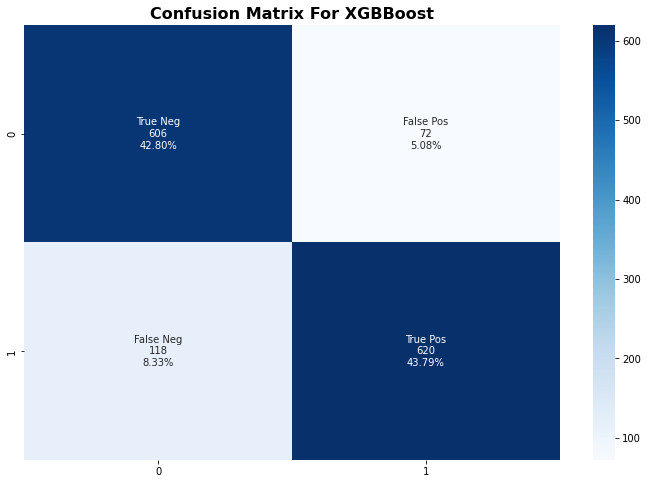

In [282]:
plot_confusion_matrix(prediction, "XGBBoost")